In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/movie_pairs.csv")  # columns: col1, col2, label

# Get unique movies across both columns
unique_movies = set(df['Movie1']).union(set(df['Movie2']))
num_movies = len(unique_movies)

print(f"Total unique movies: {num_movies}")


Total unique movies: 30


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MoviePairsDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)
        # Map movie IDs to consecutive integers starting from 0
        self.movie2idx = {movie: idx for idx, movie in enumerate(sorted(set(self.df['Movie1']).union(set(self.df['Movie2']))))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        movie_a = self.movie2idx[row['Movie1']]
        movie_b = self.movie2idx[row['Movie2']]
        label = row['Label']
        return torch.tensor(movie_a, dtype=torch.long), \
               torch.tensor(movie_b, dtype=torch.long), \
               torch.tensor(label, dtype=torch.float)


In [ ]:
batch_size = 64

dataset = MoviePairsDataset(df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
for movie_a, movie_b, label in dataloader:
    print(movie_a.shape, movie_b.shape, label.shape)
    break
# Output: torch.Size([64]) torch.Size([64]) torch.Size([64])


torch.Size([64]) torch.Size([64]) torch.Size([64])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MovieEmbeddingModel(nn.Module):
    def __init__(self, num_movies, emb_dim=128):
        super().__init__()

        # Trainable lookup table (Word2Vec-style)
        self.movie_embedding = nn.Embedding(num_movies, emb_dim)

        # Optional projection head (helps training)
        self.projection = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, movie_ids):
        """
        movie_ids: Tensor of shape [batch_size]
        """
        x = self.movie_embedding(movie_ids)     # [B, D]
        x = self.projection(x)                   # [B, D]
        x = F.normalize(x, p=2, dim=1)           # unit vectors
        return x


In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, z1, z2, label):
        """
        z1, z2: embeddings [B, D]
        label: 1 = similar, 0 = dissimilar
        """
        distance = F.pairwise_distance(z1, z2)

        loss = label * distance.pow(2) + \
               (1 - label) * torch.clamp(self.margin - distance, min=0).pow(2)

        return loss.mean()


In [ ]:
num_movies = 30      # example
emb_dim = 128
epochs = 100

model = MovieEmbeddingModel(num_movies, emb_dim)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

for epoch in range(epochs):
    total_loss = 0

    for movie_a, movie_b, label in dataloader:
        label = label.float()

        z1 = model(movie_a)
        z2 = model(movie_b)

        loss = criterion(z1, z2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(dataloader):.4f}")


Epoch 1 | Loss: 0.4742
Epoch 2 | Loss: 0.1759
Epoch 3 | Loss: 0.1467
Epoch 4 | Loss: 0.1307
Epoch 5 | Loss: 0.1182
Epoch 6 | Loss: 0.1117
Epoch 7 | Loss: 0.1076
Epoch 8 | Loss: 0.1053
Epoch 9 | Loss: 0.1028
Epoch 10 | Loss: 0.1013
Epoch 11 | Loss: 0.1008
Epoch 12 | Loss: 0.0997
Epoch 13 | Loss: 0.0994
Epoch 14 | Loss: 0.0992
Epoch 15 | Loss: 0.0986
Epoch 16 | Loss: 0.0985
Epoch 17 | Loss: 0.0978
Epoch 18 | Loss: 0.0977
Epoch 19 | Loss: 0.0979
Epoch 20 | Loss: 0.0979
Epoch 21 | Loss: 0.0974
Epoch 22 | Loss: 0.0979
Epoch 23 | Loss: 0.0973
Epoch 24 | Loss: 0.0972
Epoch 25 | Loss: 0.0976
Epoch 26 | Loss: 0.0972
Epoch 27 | Loss: 0.0972
Epoch 28 | Loss: 0.0969
Epoch 29 | Loss: 0.0974
Epoch 30 | Loss: 0.0971
Epoch 31 | Loss: 0.0965
Epoch 32 | Loss: 0.0970
Epoch 33 | Loss: 0.0968
Epoch 34 | Loss: 0.0966
Epoch 35 | Loss: 0.0969
Epoch 36 | Loss: 0.0968
Epoch 37 | Loss: 0.0974
Epoch 38 | Loss: 0.0970
Epoch 39 | Loss: 0.0966
Epoch 40 | Loss: 0.0961
Epoch 41 | Loss: 0.0970
Epoch 42 | Loss: 0.0966
E

In [ ]:
# movie_embedding.weight contains all learned embeddings
movie_embeddings = model.movie_embedding.weight  # shape: [num_movies, emb_dim]

In [ ]:
movie_id = 5  # integer index of movie (0 to num_movies-1)
vec = movie_embeddings[movie_id]
print(vec.shape)  # torch.Size([128])
print(vec)        # the actual vector


torch.Size([128])
tensor([-1.5699, -0.0742,  2.8003,  0.7633, -0.8301,  1.7987,  0.9541,  0.0815,
         0.6971, -0.7508,  0.8906,  0.4936, -0.9729,  0.3364, -0.8217,  0.4156,
        -0.2473,  1.3470, -0.0699,  0.2273,  0.7757,  0.2779, -0.8109,  0.6295,
        -0.6264, -0.2159, -0.9351, -0.3226,  2.4752,  1.0387, -2.6489,  1.7424,
         0.8840, -2.2477, -0.3034, -1.2172,  0.2130, -0.8088,  0.9428,  0.0279,
         1.6068, -0.7007,  0.5829,  1.1933,  0.5557, -2.1960, -1.7414,  1.5595,
        -0.2025,  0.9164,  1.1274,  1.1208, -0.3919,  0.5393,  0.1013, -0.6524,
        -1.0920, -0.4429, -0.5125,  1.1199, -1.2408,  0.0494, -0.1398,  1.7634,
         0.4362,  1.5687, -0.2885,  0.7515,  0.2490, -0.1241,  1.3782, -0.3702,
        -2.8754,  0.7310,  0.0811,  0.0774, -0.1057, -0.4385, -1.4144, -0.8387,
         0.9975,  0.4214,  0.2588,  0.2906,  1.0271,  0.6838, -0.2722, -0.1885,
        -0.4857,  0.6800, -1.4410, -0.9141,  1.2632,  0.6083,  0.4670, -0.1006,
        -2.1392, -1.60

In [ ]:
import torch
from torch.nn.functional import cosine_similarity

query_id = 3
query_vec = movie_embeddings[query_id].unsqueeze(0)  # shape [1, emb_dim]

# Compute similarity with all movies
similarities = cosine_similarity(query_vec, movie_embeddings)  # [num_movies]

# Get top 5 similar movies (excluding itself)
topk = torch.topk(similarities, k=6)  # returns values and indices
similar_movie_indices = topk.indices[1:]  # skip the first one (itself)
print(similar_movie_indices)


tensor([29, 15, 11,  8, 16])


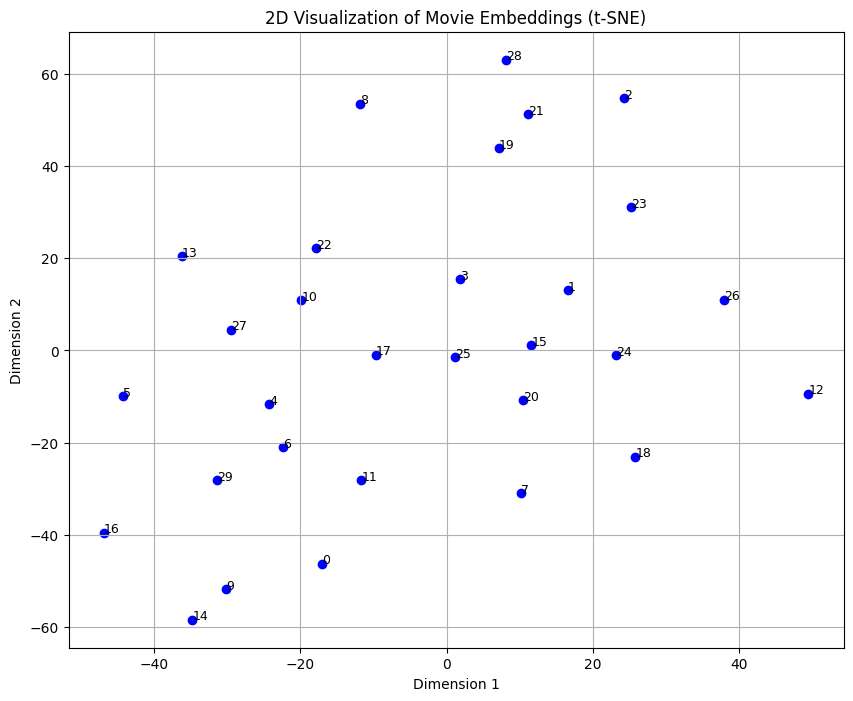

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = model.movie_embedding.weight.detach().cpu().numpy()  # [30, 128]

# t-SNE with small perplexity
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], color='blue')

# Annotate points with movie indices
for i, (x, y) in enumerate(emb_2d):
    plt.text(x+0.01, y+0.01, str(i), fontsize=9)

plt.title("2D Visualization of Movie Embeddings (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


Query movie index: 0
Top 2 similar movie indices: [29, 11]


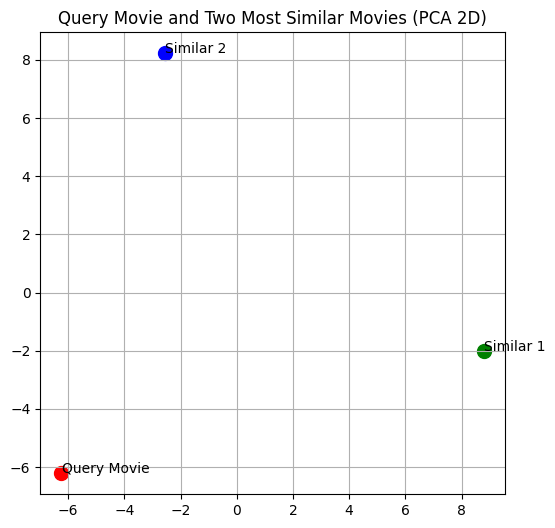

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.nn.functional import cosine_similarity

# 1️⃣ Get embeddings
embeddings = model.movie_embedding.weight.detach()  # [num_movies, emb_dim]

# 2️⃣ Choose a query movie
query_idx = 0  # pick the movie index you want

# 3️⃣ Compute cosine similarity with all movies
query_vec = embeddings[query_idx].unsqueeze(0)  # [1, emb_dim]
similarities = cosine_similarity(query_vec, embeddings)  # [num_movies]

# 4️⃣ Find top 2 similar movies (excluding itself)
topk = torch.topk(similarities, k=3)  # top 3: includes the movie itself
indices = topk.indices.tolist()        # list of 3 indices
print(f"Query movie index: {query_idx}")
print(f"Top 2 similar movie indices: {indices[1:]}")

# 5️⃣ Get the embeddings of these 3 movies
selected_emb = embeddings[indices]  # [3, emb_dim]

# 6️⃣ Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(selected_emb.numpy())

# 7️⃣ Plot
plt.figure(figsize=(6, 6))
colors = ['red', 'green', 'blue']
labels = ['Query Movie', 'Similar 1', 'Similar 2']

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, color=colors[i], s=100)
    plt.text(x+0.01, y+0.01, labels[i], fontsize=10)

plt.title("Query Movie and Two Most Similar Movies (PCA 2D)")
plt.grid(True)
plt.show()


In [ ]:
# Invert the mapping
idx2movie = {idx: movie for movie, idx in dataset.movie2idx.items()}


In [ ]:
dataset.movie2idx.items()

dict_items([('1: Nenokkadine', 0), ('Agent Sai Srinivasa Athreya', 1), ('Akhanda', 2), ('Ala Vaikunthapurramuloo', 3), ('Arjun Reddy', 4), ('Athadu', 5), ('Baahubali 2: The Conclusion', 6), ('Baahubali: The Beginning', 7), ('Bharat Ane Nenu', 8), ('Dookudu', 9), ('Eega', 10), ('Geetha Govindam', 11), ('Jersey', 12), ('Karthikeya 2', 13), ('Liger', 14), ('Magadheera', 15), ('Mahanati', 16), ('Major', 17), ('Manam', 18), ('Pokiri', 19), ('Pushpa: The Rise', 20), ('RRR', 21), ('Race Gurram', 22), ('Radhe Shyam', 23), ('Rangasthalam', 24), ('Saaho', 25), ('Shyam Singha Roy', 26), ('Sita Ramam', 27), ('Srimanthudu', 28), ('Vakeel Saab', 29)])

In [ ]:
query_idx = 3
top3_indices = indices  # from previous cosine similarity/topk

# Get the movie names
movie_names = [idx2movie[i] for i in top3_indices]
print("Movies plotted:")
for i, name in enumerate(movie_names):
    label = "Query Movie" if i==0 else f"Similar {i}"
    print(f"{label}: {name}")


Movies plotted:
Query Movie: 1: Nenokkadine
Similar 1: Vakeel Saab
Similar 2: Geetha Govindam


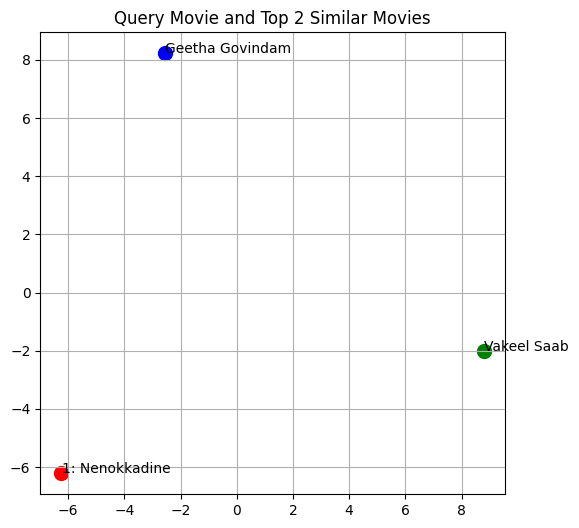

In [ ]:
plt.figure(figsize=(6,6))
colors = ['red', 'green', 'blue']

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, color=colors[i], s=100)
    plt.text(x+0.01, y+0.01, movie_names[i], fontsize=10)  # show names instead of generic label

plt.title("Query Movie and Top 2 Similar Movies")
plt.grid(True)
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get all embeddings
embeddings = model.movie_embedding.weight.detach()  # [num_movies, emb_dim]

# Convert to numpy for PCA
embeddings_np = embeddings.cpu().numpy()


In [ ]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_np)  # shape [num_movies, 2]


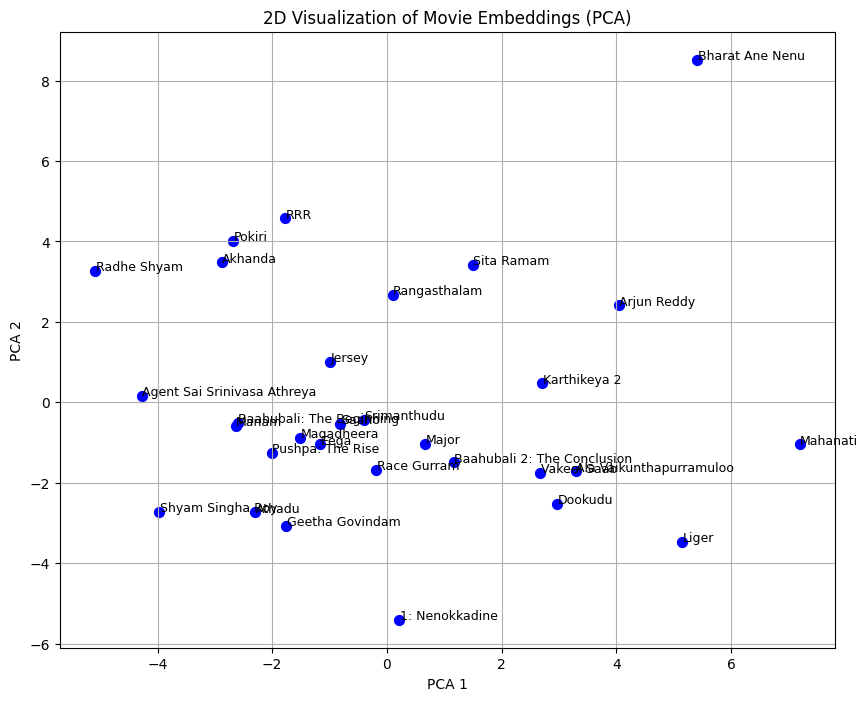

In [ ]:
plt.figure(figsize=(10, 8))

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, color='blue', s=50)
    plt.text(x+0.01, y+0.01, idx2movie[i], fontsize=9)

plt.title("2D Visualization of Movie Embeddings (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MoviePredictor(nn.Module):
    def __init__(self, num_movies=30, emb_dim=128):
        super().__init__()
        self.emb = nn.Embedding(num_movies, emb_dim)  # lookup embeddings
        self.output = nn.Linear(emb_dim, num_movies)   # predict logits for all movies

    def forward(self, movie_a):
        x = self.emb(movie_a)          # [B, D]
        logits = self.output(x)        # [B, num_movies]
        return logits


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
model = MoviePredictor(num_movies=num_movies, emb_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

for epoch in range(epochs):
    total_loss = 0
    for movie_a, movie_b,_ in dataloader:  # dataloader yields pairs
        logits = model(movie_a)
        loss = criterion(logits, movie_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(dataloader):.4f}")


Epoch 1 | Loss: 3.5102
Epoch 2 | Loss: 3.4098
Epoch 3 | Loss: 3.3407
Epoch 4 | Loss: 3.2872
Epoch 5 | Loss: 3.2447
Epoch 6 | Loss: 3.2067
Epoch 7 | Loss: 3.1764
Epoch 8 | Loss: 3.1483
Epoch 9 | Loss: 3.1259
Epoch 10 | Loss: 3.1058
Epoch 11 | Loss: 3.0877
Epoch 12 | Loss: 3.0719
Epoch 13 | Loss: 3.0557
Epoch 14 | Loss: 3.0434
Epoch 15 | Loss: 3.0316
Epoch 16 | Loss: 3.0218
Epoch 17 | Loss: 3.0121
Epoch 18 | Loss: 3.0037
Epoch 19 | Loss: 2.9957
Epoch 20 | Loss: 2.9889
Epoch 21 | Loss: 2.9816
Epoch 22 | Loss: 2.9756
Epoch 23 | Loss: 2.9708
Epoch 24 | Loss: 2.9656
Epoch 25 | Loss: 2.9598
Epoch 26 | Loss: 2.9559
Epoch 27 | Loss: 2.9521
Epoch 28 | Loss: 2.9473
Epoch 29 | Loss: 2.9427
Epoch 30 | Loss: 2.9404
Epoch 31 | Loss: 2.9375
Epoch 32 | Loss: 2.9335
Epoch 33 | Loss: 2.9307
Epoch 34 | Loss: 2.9283
Epoch 35 | Loss: 2.9259
Epoch 36 | Loss: 2.9239
Epoch 37 | Loss: 2.9208
Epoch 38 | Loss: 2.9196
Epoch 39 | Loss: 2.9164
Epoch 40 | Loss: 2.9138
Epoch 41 | Loss: 2.9144
Epoch 42 | Loss: 2.9124
E

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get embeddings from your trained model
# model.emb for the predictive Word2Vec-style model
embeddings = model.emb.weight.detach()  # shape [num_movies, emb_dim]

# Convert to numpy for PCA
embeddings_np = embeddings.cpu().numpy()


In [ ]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings_np)  # shape [num_movies, 2]


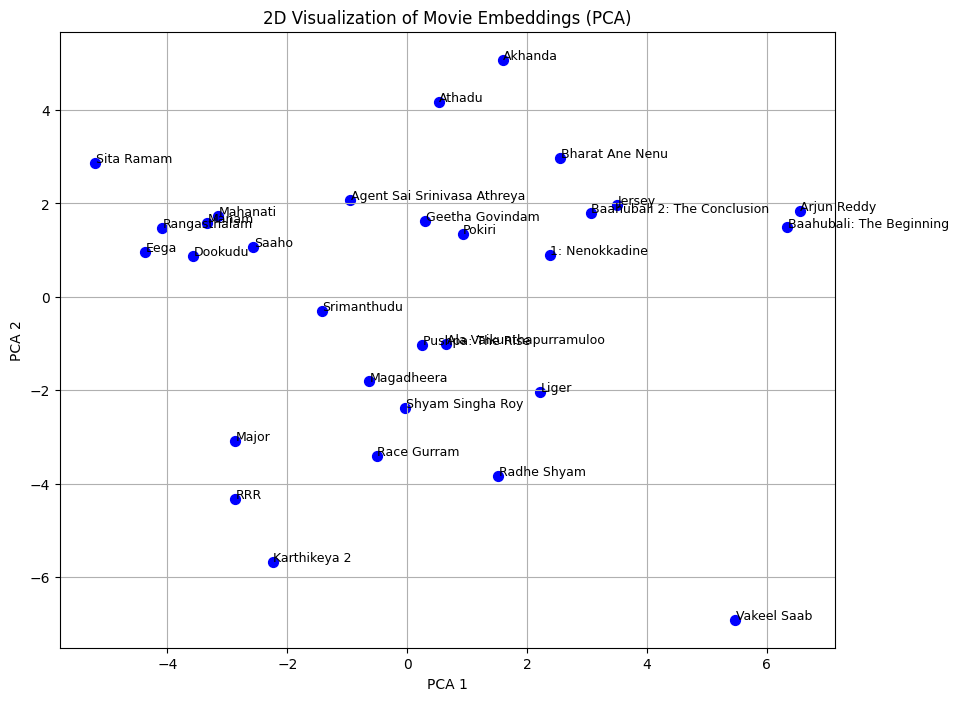

In [ ]:
plt.figure(figsize=(10, 8))

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, color='blue', s=50)
    plt.text(x+0.01, y+0.01, idx2movie[i], fontsize=9)  # show movie names

plt.title("2D Visualization of Movie Embeddings (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()
